# Multiyear Data Analysis

In [1]:
import calendar
import json
import logging
import os
import pathlib
import warnings
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pvlib
import rdtools
from scipy import stats
import seaborn as sns
import psm3tmy

logging.basicConfig()
LOGGER = logging.getLogger()
LOGGER.setLevel(logging.INFO)

os.environ['NUMEXPR_MAX_THREADS'] = '30'
LOGGER.info('NumExpr max threads: %s', os.getenv('NUMEXPR_MAX_THREADS'))

sns.set(font_scale=1.5)
plt.ion()

INFO:root:NumExpr max threads: 30


In [2]:
NREL_API_KEY = os.getenv('NREL_API_KEY', 'DEMO_KEY')
EMAIL = os.getenv('EMAIL', 'bwana.marko@yahoo.com')
LOGGER.info(NREL_API_KEY)
LOGGER.info(EMAIL)

INFO:root:DEMO_KEY
INFO:root:bwana.marko@yahoo.com


In [3]:
# no inverters, just DC power
# INVERTERS = pvlib.pvsystem.retrieve_sam('CECInverter')
# INVERTER_10K = INVERTERS['SMA_America__SB10000TL_US__240V_']

# choose typical front-contact silicon modules
CECMODS = pvlib.pvsystem.retrieve_sam('CECMod')
# for now, for simplicity, just one mono-silicon module, mono
CECMOD_MONO = CECMODS['Canadian_Solar_Inc__CS6X_300M']
CECMOD_MONO

Technology            Mono-c-Si
Bifacial                      0
STC                      300.03
PTC                       273.6
A_c                       1.852
Length                    1.931
Width                     0.959
N_s                          72
I_sc_ref                   8.74
V_oc_ref                   45.0
I_mp_ref                   8.22
V_mp_ref                   36.5
alpha_sc               0.004326
beta_oc                -0.15372
T_NOCT                     44.3
a_ref                  1.861184
I_L_ref                8.745869
I_o_ref                     0.0
R_s                    0.366101
R_sh_ref             545.178589
Adjust                 4.722239
gamma_r                  -0.442
BIPV                          N
Version       SAM 2018.11.11 r2
Date                   1/3/2019
Name: Canadian_Solar_Inc__CS6X_300M, dtype: object

In [4]:
# read years from SURFRAD path
PATH = pathlib.Path(
    'C:/Users/SFValidation3/Desktop/Mark Mikofski/SURFRAD/Sioux_Falls_SD')
YEARS = list(str(y) for y in PATH.iterdir())

TMY2_PATH = 'C:/Users/SFValidation3/Desktop/Mark Mikofski/SURFRAD/14944.tm2'
TMY3_PATH = 'C:/Users/SFValidation3/Desktop/Mark Mikofski/SURFRAD/726510TYA.CSV'
TMY3_PATH_2 = 'C:/Users/SFValidation3/Desktop/Mark Mikofski/SURFRAD/726515TYA.CSV'
# TMY3_PATH_3 = 'C:/Users/SFValidation3/Desktop/Mark Mikofski/SURFRAD/.CSV'
# TMY3_PATH_4 = 'C:/Users/SFValidation3/Desktop/Mark Mikofski/SURFRAD/.CSV'

In [5]:
np.array([y.rsplit('\\', 1)[1] for y in YEARS])

array(['2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010',
       '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018',
       '2019', '2020', '2021'], dtype='<U4')

In [6]:
# accumulate daily energy
EDAILY = {}

# for year in YEARS:
year = YEARS[-5]  # only do 1 year that was 5 years ago
LOGGER.info('year: %s', year)
yearpath = PATH / year
data = [pvlib.iotools.read_surfrad(f) for f in yearpath.iterdir()]
dfs, heads = zip(*data)
df = pd.concat(dfs)
header = heads[0]

INFO:root:year: C:\Users\SFValidation3\Desktop\Mark Mikofski\SURFRAD\Sioux_Falls_SD\2017


In [7]:
header

{'name': 'Sioux Falls',
 'latitude': 43.73,
 'longitude': -96.62,
 'elevation': 473.0,
 'surfrad_version': 1,
 'tz': 'UTC'}

In [8]:
# get solar position
LATITUDE = header['latitude']
LONGITUDE = header['longitude']
ELEVATION = header['elevation']

In [9]:
LATITUDE, LONGITUDE, ELEVATION

(43.73, -96.62, 473.0)

In [10]:
TIMES = df.index
sp = pvlib.solarposition.get_solarposition(
        TIMES, LATITUDE, LONGITUDE)
solar_zenith = sp.apparent_zenith.values
solar_azimuth = sp.azimuth.values
zenith = sp.zenith.values
ghi = df.ghi.values

In [11]:
any(ghi<0)

True

In [12]:
# zero out negative (night?) GHI
ghi = np.where(ghi < 0, 0, ghi)

In [13]:
any(ghi<0)

False

In [14]:
# we don't trust SURFRAD DNI or DHI b/c it's often missing
# dni = df.dni.values
# dhi = df.dhi.values

# we also don't trust air temp, RH, or pressure, same reason
# temp_air = df.temp_air.values
# relative_humidity = df.relative_humidity.values
# pressure = df.pressues.values
# wind_speed = df.wind_speed.values

In [15]:
# check the calculated zenith from SURFRAD
ze_mbe = 100 * (
    sum(solar_zenith - df.solar_zenith.values)
    / sum(df.solar_zenith.values))
LOGGER.info(f'zenith MBE: {ze_mbe}%')

INFO:root:zenith MBE: 0.0031690881300330404%


In [16]:
# get irrad components
irrad = pvlib.irradiance.erbs(ghi, zenith, TIMES)
dni = irrad.dni.values
dhi = irrad.dhi.values
kt = irrad.kt.values  # clearness index

In [17]:
# calculate irradiance inputs
dni_extra = pvlib.irradiance.get_extra_radiation(TIMES).values

In [18]:
# estimate air temp
year_start = year.rsplit('\\', 1)[1]
year_minutes = pd.date_range(
    start=year_start, freq='T', periods=527040, tz='UTC')
TL = pvlib.clearsky.lookup_linke_turbidity(TIMES, LATITUDE, LONGITUDE)
AM = pvlib.atmosphere.get_relative_airmass(solar_zenith)
PRESS = pvlib.atmosphere.alt2pres(ELEVATION)
AMA = pvlib.atmosphere.get_absolute_airmass(AM, PRESS)
CS = pvlib.clearsky.ineichen(solar_zenith, AM, TL, ELEVATION, dni_extra)
cs_temp_air = rdtools.clearsky_temperature.get_clearsky_tamb(
    year_minutes, LATITUDE, LONGITUDE)

In [19]:
year_start

'2017'

<AxesSubplot:label='7d534a2f-3f49-4634-ad39-84b29f2bc0c9'>

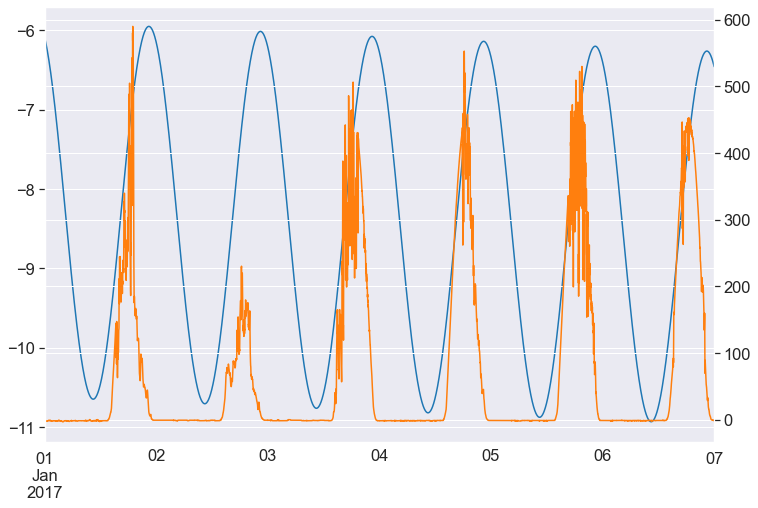

In [20]:
fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twinx()  # add a second y-axis
jan1, jan7 = '2017-01-01T00:00:00-00:00', '2017-01-07T00:00:00-00:00'
cs_temp_air[jan1:jan7].plot(ax=ax1, c='tab:blue')
df.ghi[jan1:jan7].plot(ax=ax2, c='tab:orange')

In [21]:
daze = cs_temp_air.size // (24*60)
daze

366

In [22]:
cs_temp_air.index.values.reshape((daze, 1440))[0]

array(['2017-01-01T00:00:00.000000000', '2017-01-01T00:01:00.000000000',
       '2017-01-01T00:02:00.000000000', ...,
       '2017-01-01T23:57:00.000000000', '2017-01-01T23:58:00.000000000',
       '2017-01-01T23:59:00.000000000'], dtype='datetime64[ns]')

In [23]:
cs_temp_daily = cs_temp_air.values.reshape((daze, 1440)) + 273.15
cs_temp_daily[0]

array([267.06128104, 267.05712486, 267.05292747, ..., 267.01053212,
       267.0065048 , 267.00243608])

In [24]:
cs_temp_daily[0].min(), cs_temp_daily[0].max()

(262.5038840956665, 267.19624809440035)

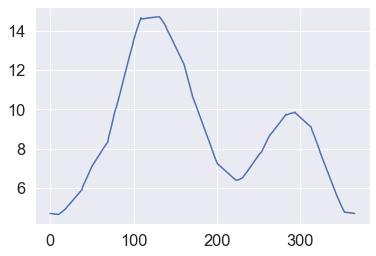

In [25]:
daily_delta_temp = np.array([
    td.max()-td.min() for td in cs_temp_daily
])
plt.plot(daily_delta_temp)

In [64]:
from pandas.tseries.frequencies import to_offset

ghi_roll = df.ghi.rolling(window='30min').mean()
ghi_roll.index = ghi_roll.index - to_offset('15min')

In [65]:
ghi_hourly = df.ghi.resample('H').mean()
ghi_hourly.index = ghi_hourly.index + to_offset('30min')

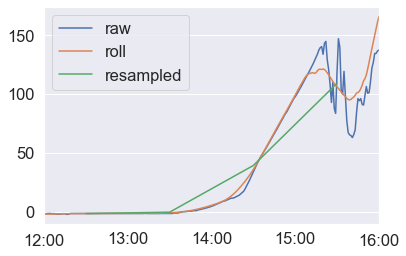

In [66]:
pm12, pm4 = '2017-01-01T12:00:00-00:00', '2017-01-01T16:00:00-00:00'
df[pm12:pm4].ghi.plot(label='raw')
ghi_roll[pm12:pm4].plot(label='roll')
ghi_hourly[pm12:pm4].resample('1min').interpolate().plot(label='resampled')
plt.legend()

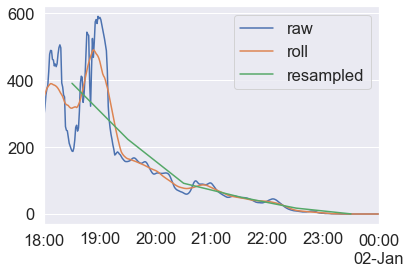

In [67]:
pm6,jan2am12 = '2017-01-01T18:00:00-00:00', '2017-01-02T00:00:00-00:00'
df[pm6:jan2am12].ghi.plot(label='raw')
ghi_roll[pm6:jan2am12].plot(label='roll')
ghi_hourly[pm6:jan2am12].resample('1min').interpolate().plot(label='resampled')
plt.legend()

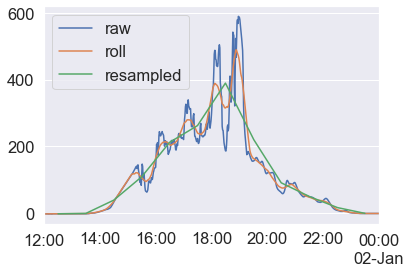

In [68]:
df[pm12:jan2am12].ghi.plot(label='raw')
ghi_roll[pm12:jan2am12].plot(label='roll')
ghi_hourly[pm12:jan2am12].resample('1min').interpolate().plot(label='resampled')
plt.legend()

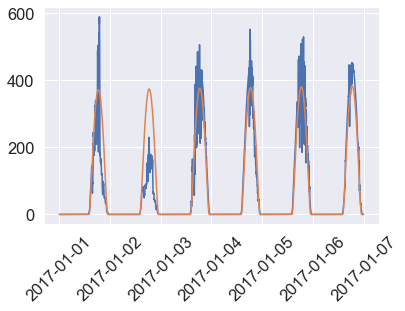

In [69]:
plt.plot(
    CS[jan1:jan7].index, ghi[:1440*6+1],
    CS[jan1:jan7].index, CS.ghi.values[:1440*6+1]
)
plt.xticks(rotation=45);

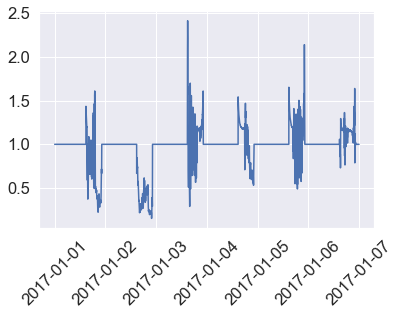

In [70]:
MIN_GHI = 50  # W/m2
# scale clear sky air temp to SURFRAD, and zero out night
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # FIXME: use Kelvin, scaling air temps in degC is backwards for negative
    # TODO: use rolling('10T'), ghi is too jagged for scaling airtemp smoothly
    ghi_factor = np.where(
        CS.ghi.values <= MIN_GHI,
        1.0,
        ghi / CS.ghi.values)
plt.plot(CS[jan1:jan7].index, ghi_factor[:1440*6+1])
plt.xticks(rotation=45);

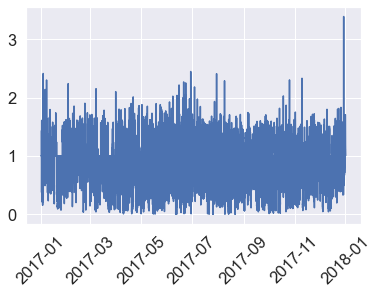

In [71]:
plt.plot(CS.index, ghi_factor)
plt.xticks(rotation=45);

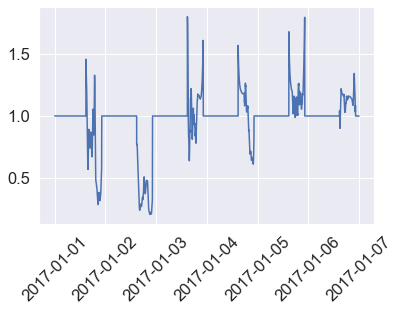

In [72]:
MIN_GHI = 50  # W/m2
ghi_roll_reindex = np.concatenate(
    [ghi_roll.values[15:],ghi_roll.values[:15]])
# scale clear sky air temp to SURFRAD, and zero out night
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # FIXME: use Kelvin, scaling air temps in degC is backwards for negative
    # TODO: use rolling('10T'), ghi is too jagged for scaling airtemp smoothly
    ghi_roll_factor = np.where(
        CS.ghi.values <= MIN_GHI,
        1.0,
        ghi_roll_reindex / CS.ghi.values)
plt.plot(CS[jan1:jan7].index, ghi_roll_factor[:1440*6+1])
plt.xticks(rotation=45);

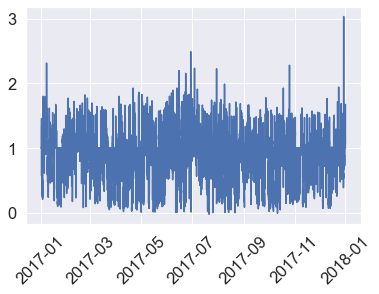

In [74]:
plt.plot(CS.index, ghi_roll_factor)
plt.xticks(rotation=45);

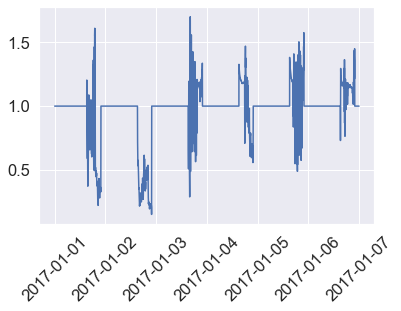

In [75]:
MIN_GHI = 100  # W/m2
# scale clear sky air temp to SURFRAD, and zero out night
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # FIXME: use Kelvin, scaling air temps in degC is backwards for negative
    # TODO: use rolling('10T'), ghi is too jagged for scaling airtemp smoothly
    ghi_factor = np.where(
        CS.ghi.values <= MIN_GHI,
        1.0,
        ghi / CS.ghi.values)
plt.plot(CS[jan1:jan7].index, ghi_factor[:1440*6+1])
plt.xticks(rotation=45);

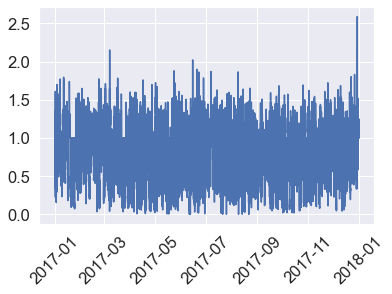

In [76]:
plt.plot(CS.index, ghi_factor)
plt.xticks(rotation=45);

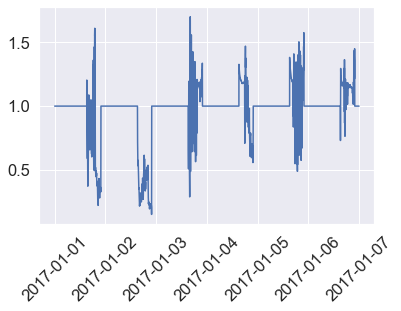

In [77]:
MIN_GHI = 100  # W/m2
ghi_roll_reindex = np.concatenate(
    [ghi_roll.values[15:],ghi_roll.values[:15]])
# scale clear sky air temp to SURFRAD, and zero out night
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # FIXME: use Kelvin, scaling air temps in degC is backwards for negative
    # TODO: use rolling('10T'), ghi is too jagged for scaling airtemp smoothly
    ghi_roll_factor = np.where(
        CS.ghi.values <= MIN_GHI,
        1.0,
        ghi_roll_reindex / CS.ghi.values)
plt.plot(CS[jan1:jan7].index, ghi_factor[:1440*6+1])
plt.xticks(rotation=45);

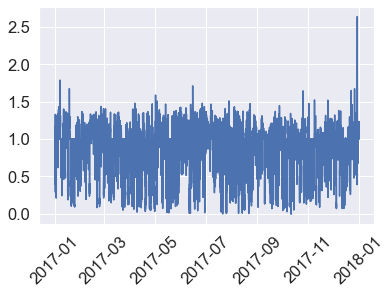

In [78]:
plt.plot(CS.index, ghi_roll_factor)
plt.xticks(rotation=45);

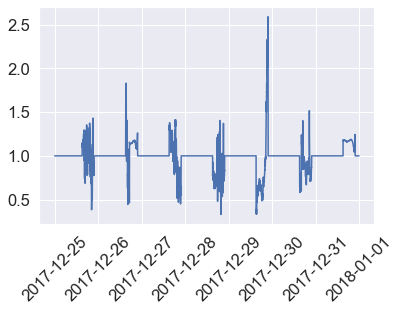

In [79]:
xmas, dec31 = '2017-12-25T00:00:00-00:00', '2018-01-01T00:00:00-00:00'
plt.plot(CS[xmas:dec31].index, ghi_factor[-1440*7:])
plt.xticks(rotation=45);

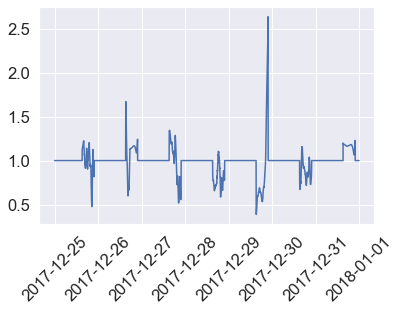

In [81]:
plt.plot(CS[xmas:dec31].index, ghi_roll_factor[-1440*7:])
plt.xticks(rotation=45);

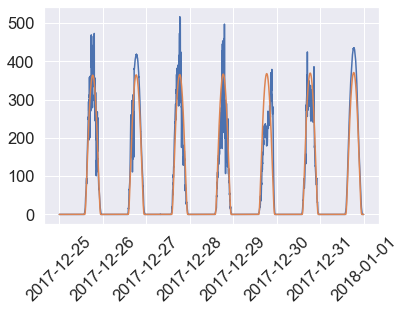

In [80]:
plt.plot(
    CS[xmas:dec31].index, ghi[-1440*7:],
    CS[xmas:dec31].index, CS.ghi.values[-1440*7:]
)
plt.xticks(rotation=45);

<AxesSubplot:>

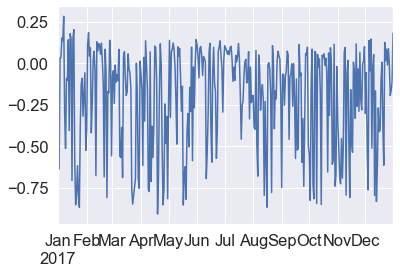

In [159]:
ghi_scale = df.ghi.resample('D').sum() / CS.ghi.resample('D').sum() - 1
ghi_scale = ghi_scale.rename('ghi_scale')
ghi_scale.plot()

<AxesSubplot:>

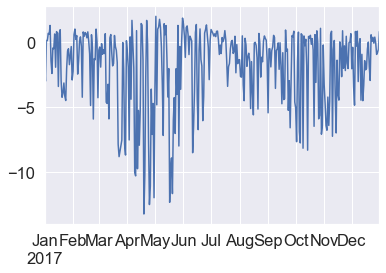

In [160]:
temp_scale = ghi_scale*daily_delta_temp[:-1]
temp_scale = temp_scale.rename('temp_scale')
temp_scale.plot()

In [166]:
temp_adj = pd.concat(
    [cs_temp_air,
     ghi_scale.resample('1min').interpolate(),
     temp_scale.resample('1min').interpolate()], axis=1).pad()
temp_adj

,Clear Sky Temperature (C),ghi_scale,temp_scale
2017-01-01 00:00:00+00:00,-6.088719,-0.287778,-1.350361
2017-01-01 00:01:00+00:00,-6.092875,-0.288021,-1.351498
2017-01-01 00:02:00+00:00,-6.097073,-0.288264,-1.352636
2017-01-01 00:03:00+00:00,-6.101311,-0.288507,-1.353774
2017-01-01 00:04:00+00:00,-6.105591,-0.288750,-1.354912
...,...,...,...
2018-01-01 23:55:00+00:00,-6.131538,0.179874,0.845050
2018-01-01 23:56:00+00:00,-6.135482,0.179874,0.845050
2018-01-01 23:57:00+00:00,-6.139468,0.179874,0.845050
2018-01-01 23:58:00+00:00,-6.143495,0.179874,0.845050


In [167]:
temp_adj['Adjusted Temp (C)'] = (
    temp_adj['Clear Sky Temperature (C)'] + temp_adj.temp_scale)
temp_adj

,Clear Sky Temperature (C),ghi_scale,temp_scale,Adjusted Temp (C)
2017-01-01 00:00:00+00:00,-6.088719,-0.287778,-1.350361,-7.439080
2017-01-01 00:01:00+00:00,-6.092875,-0.288021,-1.351498,-7.444373
2017-01-01 00:02:00+00:00,-6.097073,-0.288264,-1.352636,-7.449709
2017-01-01 00:03:00+00:00,-6.101311,-0.288507,-1.353774,-7.455085
2017-01-01 00:04:00+00:00,-6.105591,-0.288750,-1.354912,-7.460502
...,...,...,...,...
2018-01-01 23:55:00+00:00,-6.131538,0.179874,0.845050,-5.286488
2018-01-01 23:56:00+00:00,-6.135482,0.179874,0.845050,-5.290432
2018-01-01 23:57:00+00:00,-6.139468,0.179874,0.845050,-5.294418
2018-01-01 23:58:00+00:00,-6.143495,0.179874,0.845050,-5.298445


<AxesSubplot:>

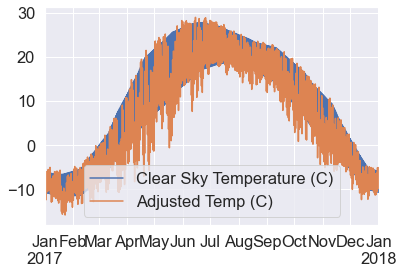

In [168]:
temp_adj[['Clear Sky Temperature (C)', 'Adjusted Temp (C)']].plot()

<AxesSubplot:>

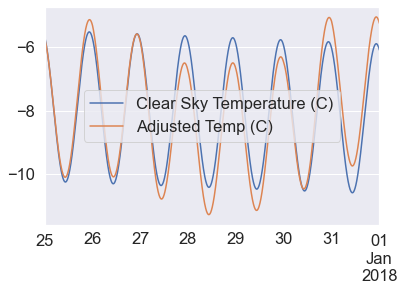

In [169]:
temp_adj[xmas:dec31][['Clear Sky Temperature (C)', 'Adjusted Temp (C)']].plot()

<AxesSubplot:>

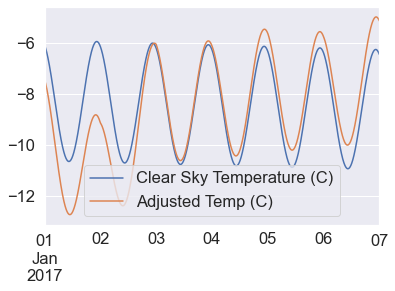

In [170]:
temp_adj[jan1:jan7][['Clear Sky Temperature (C)', 'Adjusted Temp (C)']].plot()

<AxesSubplot:label='ba04d680-6fec-4481-a683-70d9b3e6e6c0'>

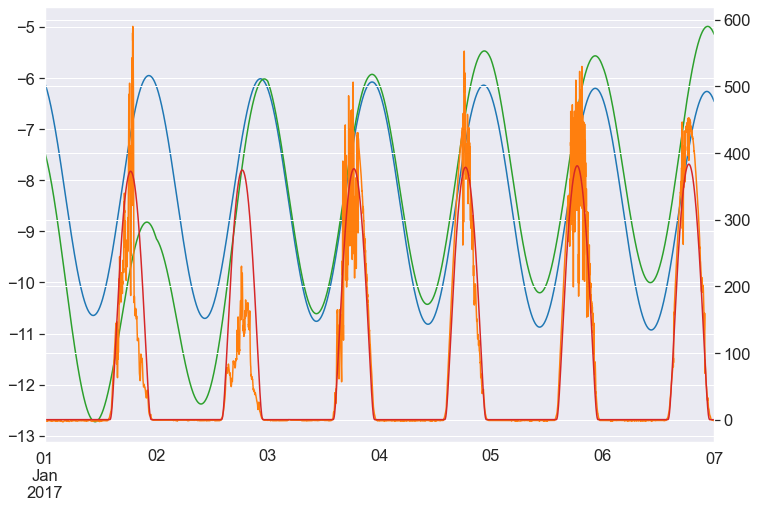

In [172]:
fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twinx()  # add a second y-axis
cs_temp_air[jan1:jan7].plot(ax=ax1, c='tab:blue')
temp_adj[jan1:jan7]['Adjusted Temp (C)'].plot(ax=ax1,c='tab:green')
df.ghi[jan1:jan7].plot(ax=ax2, c='tab:orange')
CS.ghi[jan1:jan7].plot(ax=ax2, c='tab:red')